# Based on general purpose language model, train a Length of Stay classifier

Instead of building from a MIMIC trained language model, use the general purpose ULMFit Wiki trained model

This notebook is mostly a copy of mimic_nlp_classifier_los.ipynb - but with visualizations and some debugging output removed

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc
import altair as alt

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'wiki_los_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'cl_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'wiki_los_cl_head'
cycles_file = base_path/'wiki_los_cl_num_iterations.pickle'
enc_file = 'wiki_cl_enc'
ft_file = 'wiki_los_cl_fine_tuned_'
freeze_two = base_path/'wiki_los_cl_freeze_two'
freeze_three = base_path/'wiki_los_cl_freeze_three'

training_history_file = 'wiki_los_cl_history'

Setup parameters for models

In [3]:
pct_data_sample = 0.2
lm_pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
lm_seed = 42
# for classifier, on unfrozen/full network training
# batch size of 128 GPU uses ?? GB RAM
# batch size of 96 GPU uses 22 GB RAM
# batch size of 48 GPU uses GB RAM
bs=64

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [6]:
notes_df = orig_df[orig_df.HADM_ID.notnull()].copy()
notes_df.HADM_ID = notes_df.HADM_ID.astype(int)
notes_df.shape

(1851344, 11)

In [7]:
notes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [8]:
print('Loading ADMISSIONS.csv')
a_orig = pd.read_csv(admissions_file, low_memory=False, memory_map=True)
a_orig.shape

Loading ADMISSIONS.csv


(58976, 19)

In [9]:
a_df = a_orig[['HADM_ID', 'ADMITTIME', 'DISCHTIME']].copy()
#pd.to_datetime('2014-04-09T152959.999993-0500', utc=True)
# passing format just to make sure conversion doesn't mess something up
a_df['admittime'] = pd.to_datetime(a_df.ADMITTIME, format='%Y-%m-%d %H:%M:%S')
a_df['dischtime'] = pd.to_datetime(a_df.DISCHTIME, format='%Y-%m-%d %H:%M:%S')
a_df['los'] = (a_df['dischtime'] - a_df['admittime']).astype('timedelta64[D]')
# can't use a float in neural network
a_df['los'] = a_df.los.astype(int)
# there are 98 admissions where length of stay is negative. change to 0
a_df.loc[a_df.los < 0, 'los'] = 0
a_df.head()

,HADM_ID,ADMITTIME,DISCHTIME,admittime,dischtime,los
0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,2196-04-09 12:26:00,2196-04-10 15:54:00,1
1,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,2153-09-03 07:15:00,2153-09-08 19:10:00,5
2,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,2157-10-18 19:34:00,2157-10-25 14:00:00,6
3,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,2139-06-06 16:14:00,2139-06-09 12:48:00,2
4,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,2160-11-02 02:06:00,2160-11-05 14:55:00,3


In [10]:
# make sure we only keep rows with notes
combined_df = pd.merge(a_df, notes_df, on='HADM_ID', how='right')

# passing format just to make sure conversion doesn't mess something up
combined_df['charttime'] = pd.to_datetime(combined_df.CHARTTIME, format='%Y-%m-%d %H:%M:%S')
combined_df['chartdate'] = pd.to_datetime(combined_df.CHARTDATE, format='%Y-%m-%d')
combined_df['admitdate'] = combined_df.admittime.dt.date
combined_df = combined_df[['HADM_ID', 'ROW_ID', 'admittime', 'admitdate', 'dischtime', 'los', 'chartdate', 'charttime', 'TEXT']]
combined_df.rename(columns={'HADM_ID': 'hadm_id', 'ROW_ID': 'row_id', 'TEXT': "text"}, inplace=True)
combined_df.shape

(1851344, 9)

In [11]:
# these should all be zero
print(combined_df[combined_df.los.isnull()].shape)
print(combined_df[combined_df.hadm_id.isnull()].shape)
print(combined_df[combined_df.text.isnull()].shape)

(0, 9)
(0, 9)
(0, 9)


In [12]:
combined_df.head()

,hadm_id,row_id,admittime,admitdate,dischtime,los,chartdate,charttime,text
0,165315,12144,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-10,NaT,Admission Date: [**2196-4-9**] Discharg...
1,165315,158364,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,NaT,Normal sinus rhythm. Non-diagnostic repolariza...
2,165315,158365,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,NaT,Normal sinus rhythm without diagnostic abnorma...
3,165315,754366,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-10,2196-04-10 23:52:00,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...
4,165315,754332,2196-04-09 12:26:00,2196-04-09,2196-04-10 15:54:00,1,2196-04-09,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...


In [13]:
len(combined_df.hadm_id.unique())

58361

### Use notes from day 1 of stay to predict LOS


    For each admission
        do they have notes on day 1 of stay


In [14]:
combined_df.dtypes

hadm_id               int64
row_id                int64
admittime    datetime64[ns]
admitdate            object
dischtime    datetime64[ns]
los                   int64
chartdate    datetime64[ns]
charttime    datetime64[ns]
text                 object
dtype: object

### Build data set for LOS analysis

First, find rows of data related to first day of stay

Then, combine notes from first day into one text field

In [15]:
# this is the slowest cell in pre-processing portion of the notebook 
fday = combined_df.groupby('hadm_id', as_index=False).apply(lambda g: g[
    (g.charttime >= g.admittime) & (g.charttime < (g.admittime + pd.Timedelta(hours=24)))
    |
    (g.chartdate == g.admitdate)
])

In [16]:
fday.head()

hadm_id   row_id           admittime   admitdate  \
0 1523431   100001  1206584 2117-09-11 11:46:00  2117-09-11   
1 1512590   100003   193462 2150-04-17 15:34:00  2150-04-17   
  1512591   100003   567670 2150-04-17 15:34:00  2150-04-17   
  1512592   100003   567662 2150-04-17 15:34:00  2150-04-17   
  1512596   100003   567564 2150-04-17 15:34:00  2150-04-17   

                    dischtime  los  chartdate           charttime  \
0 1523431 2117-09-17 16:45:00    6 2117-09-11 2117-09-11 11:12:00   
1 1512590 2150-04-21 17:30:00    4 2150-04-17                 NaT   
  1512591 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 11:53:00   
  1512592 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 02:47:00   
  1512596 2150-04-21 17:30:00    4 2150-04-17 2150-04-17 20:48:00   

                                                        text  
0 1523431  [**2117-9-11**] 11:12 AM\n CHEST (PA & LAT)   ...  
1 1512590  Sinus rhythm\nProlonged QT interval is nonspec...  
  1512591  59 year old male with HCV-related cirrhosis, g...  
  1512592  Chief Complaint:  coffee ground emesis, light ...  
  1512596  Chief Complaint:  GIB/HOTN\n   I saw and exami...

In [17]:
tmp = fday[['hadm_id', 'row_id']].reset_index(drop=True)
tmp['row_id'] = tmp['row_id'].astype(str)
tmp.dtypes

hadm_id     int64
row_id     object
dtype: object

In [18]:
tmp.head()

,hadm_id,row_id
0,100001,1206584
1,100003,193462
2,100003,567670
3,100003,567662
4,100003,567564


In [19]:
combined_notes_row_ids = tmp.groupby(['hadm_id'], as_index=False).agg({
    'row_id': lambda x: ",".join(x)
})
combined_notes_row_ids.head()

,hadm_id,row_id
0,100001,1206584
1,100003,"193462,567670,567662,567564,567651,567608,5676..."
2,100006,"148403,783338,1392730,1392731,1392732"
3,100007,"281959,1563229,1563230"
4,100009,"185962,1189514,1189544"


In [20]:
fday.head()

hadm_id   row_id           admittime   admitdate  \
0 1523431   100001  1206584 2117-09-11 11:46:00  2117-09-11   
1 1512590   100003   193462 2150-04-17 15:34:00  2150-04-17   
  1512591   100003   567670 2150-04-17 15:34:00  2150-04-17   
  1512592   100003   567662 2150-04-17 15:34:00  2150-04-17   
  1512596   100003   567564 2150-04-17 15:34:00  2150-04-17   

                    dischtime  los  chartdate           charttime  \
0 1523431 2117-09-17 16:45:00    6 2117-09-11 2117-09-11 11:12:00   
1 1512590 2150-04-21 17:30:00    4 2150-04-17                 NaT   
  1512591 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 11:53:00   
  1512592 2150-04-21 17:30:00    4 2150-04-18 2150-04-18 02:47:00   
  1512596 2150-04-21 17:30:00    4 2150-04-17 2150-04-17 20:48:00   

                                                        text  
0 1523431  [**2117-9-11**] 11:12 AM\n CHEST (PA & LAT)   ...  
1 1512590  Sinus rhythm\nProlonged QT interval is nonspec...  
  1512591  59 year old male with HCV-related cirrhosis, g...  
  1512592  Chief Complaint:  coffee ground emesis, light ...  
  1512596  Chief Complaint:  GIB/HOTN\n   I saw and exami...

In [21]:
combined_fday = fday.groupby(['hadm_id', 'los'], as_index=False).agg({
    'text': lambda x: "\n\n\n\n".join(x)
})

In [22]:
combined_fday.head()

,hadm_id,los,text
0,100001,6,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
1,100003,4,Sinus rhythm\nProlonged QT interval is nonspec...
2,100006,12,Sinus tachycardia\nLeft axis deviation - anter...
3,100007,7,Sinus rhythm\nAtrial premature complex\nConsid...
4,100009,4,Sinus bradycardia. Left atrial abnormality. ...


In [23]:
combined_fday.shape

(55353, 3)

In [24]:
len(combined_fday.los.unique())

159

In [25]:
print(combined_fday.los.value_counts().head(10))
print(combined_fday.los.value_counts().tail(10))

4    5686
2    5389
3    4863
5    4554
6    4001
7    3503
1    3257
8    2825
9    2392
0    2062
Name: los, dtype: int64
150    1
181    1
140    1
109    1
163    1
141    1
136    1
173    1
206    1
191    1
Name: los, dtype: int64


In [26]:
s = combined_fday.los.value_counts()
print('Number of records where length of stay is unique to that person:', len(s[s == 1]))

Number of records where length of stay is unique to that person: 23


In [27]:
# min
print('Min LOS:', combined_fday.los.min())
# max
print('Max LOS:', combined_fday.los.max())
# median
print('Median LOS:', combined_fday.los.median())
# mean
print('Mean LOS:', combined_fday.los.mean())
print('Mode LOS:', combined_fday.los.mode()[0]) # returns a series, just want the value

Min LOS: 0
Max LOS: 206
Median LOS: 6.0
Mean LOS: 9.581088649215038
Mode LOS: 4


### Truncate LOS to max of 10

In [28]:
trunc_fday = combined_fday.copy()
trunc_fday.loc[trunc_fday.los > 9, 'los'] = 10
trunc_fday.head()

,hadm_id,los,text
0,100001,6,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
1,100003,4,Sinus rhythm\nProlonged QT interval is nonspec...
2,100006,10,Sinus tachycardia\nLeft axis deviation - anter...
3,100007,7,Sinus rhythm\nAtrial premature complex\nConsid...
4,100009,4,Sinus bradycardia. Left atrial abnormality. ...


In [29]:
s = trunc_fday.los.value_counts()
len(s[s == 1])

0

In [30]:
print(trunc_fday.los.value_counts().head(15))

10    16821
4      5686
2      5389
3      4863
5      4554
6      4001
7      3503
1      3257
8      2825
9      2392
0      2062
Name: los, dtype: int64


In [31]:
rowid_sample = combined_notes_row_ids.sample(frac=pct_data_sample, random_state=seed)

In [32]:
df = trunc_fday.sample(frac=pct_data_sample, random_state=seed)
df.shape

(11071, 3)

In [33]:
# should be 5535 - 100% overlap
len(set(rowid_sample.hadm_id.unique()) & set(df.hadm_id.unique()))

11071

In [34]:
len(df.hadm_id.unique())

11071

In [35]:
print('--------- stats on 10% random sample ---------')
print('Min LOS:', df.los.min())
print('Max LOS:', df.los.max())
print('Median LOS:', df.los.median())
print('Mean LOS:', df.los.mean())
print('Mode LOS:', df.los.mode()[0]) # returns a series, just want the value

--------- stats on 10% random sample ---------
Min LOS: 0
Max LOS: 10
Median LOS: 6.0
Mean LOS: 6.053382711588836
Mode LOS: 10


In [36]:
#s.apply(pd.Series).stack().reset_index(drop=True)

# some patients only have 1 note

r = pd.concat([
    rowid_sample[rowid_sample['row_id'].str.contains(',')].groupby(['hadm_id'], as_index=False).agg({
        'row_id': lambda x: x.str.split(',')
    }),
    rowid_sample[~rowid_sample['row_id'].str.contains(',')]
])
row_ids = r.row_id.apply(pd.Series).stack().reset_index(drop=True)
row_ids = row_ids.astype(int)

In [37]:
print(row_ids.shape)         # 33,914
print(len(row_ids.unique())) # 33,914

(67416,)
67416


In [38]:
# compare overlap between these notes and language model notes set
lm_df = orig_df.sample(frac=lm_pct_data_sample, random_state=42)
print('rows in dataframe for NN:', len(row_ids.unique()))
print('rows in language model:', len(lm_df.ROW_ID.unique()))
print('row_ids in both:', len(set(row_ids.unique()) & set(lm_df.ROW_ID.unique())))

rows in dataframe for NN: 67416
rows in language model: 208318
row_ids in both: 6874


## Now for some Deep Learning

In [39]:
# What if LOS was a string? Would accuracy, memory, or training time change?
#df.los = df.los.astype(int)
#df.dtypes

### Create language model without fine-tuning to MIMIC notes

In [40]:
tmpfile = base_path/lm_file

if os.path.isfile(tmpfile):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('creating new language model')
    lm_df = orig_df.sample(frac=pct_data_sample, random_state=lm_seed)
    lm = (TextList.from_df(lm_df, base_path, cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=lm_seed)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    lm.save(tmpfile)
    print('completed creating new language model')

loading existing language model


In [41]:
learn = language_model_learner(lm, AWD_LSTM, drop_mult=0.3)
learn.save_encoder(enc_file)

#### This is a very CPU and RAM intensive process - no GPU involved

In [42]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data bunch')
else:
    print('creating new data bunch')
    data_cl = (TextList.from_df(df, base_path, cols='text', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set seed for repeatability
               .label_from_df(cols='los')
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

created new data bunch


### Account for class imbalance

Using weighted F1 as metric

See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Also adjust weights of network output to reduce likelihood of los > 9

In [46]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)
print('loaded encoder')

loaded encoder


In [44]:
label_counts = df.groupby('los').size()
orig_count = label_counts.iloc[-1]
label_counts.iloc[-1] = orig_count * 50
label_sum = len(df.los) + (label_counts.iloc[-1] - orig_count)
weights = [1 - count/label_sum for count in label_counts]

In [45]:
loss_weights = torch.FloatTensor(weights).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)
learn.crit

functools.partial(<function cross_entropy at 0x7fb1c3b44488>, weight=tensor([0.9977, 0.9964, 0.9937, 0.9945, 0.9937, 0.9947, 0.9956, 0.9959, 0.9968,
        0.9975, 0.0435], device='cuda:0'))

In [ ]:
# with P100/P40 this takes maybe 5 minutes
# with 2017 macbook pro, intel core i7 3.1Ghz, this takes about 160 minutes
learn.lr_find()

In [ ]:
learn.recorder.plot()

Change learning rate based on results from the above plot.

Next several cells test various learning rates to find ideal learning rate

### Train with selected learning rate

Results from `learn.fit_one_cycle()`

    Training new initial learner

    epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time


In [47]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    learn.load_encoder(enc_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

Training new initial learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.163698,2.112931,0.330172,0.185630,07:02


Saving new learner
Finished generating new learner


### Results from the freeze_two learner

With `learn.fit_one_cycle()`

    epoch 	train_loss 	valid_loss 	accuracy 	f_beta 	time

In [48]:
if os.path.isfile(str(freeze_two) + '.pth'):
    learn.load(freeze_two)
    print('loaded freeze_two learner')
else:
    print('Training new freeze_two learner')
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_two learner')
    learn.save(freeze_two)
    print('Finished generating new freeze_two learner')

Training new freeze_two learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.142020,2.107906,0.321138,0.173859,06:30


Saving new freeze_two learner
Finished generating new freeze_two learner


In [49]:
if os.path.isfile(str(freeze_three) + '.pth'):
    learn.load(freeze_three)
    print('loaded freeze_three learner')
else:
    print('Training new freeze_three learner')
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_three learner')
    learn.save(freeze_three)
    print('Finished generating new freeze_three learner')

Training new freeze_three learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.061233,2.079508,0.336043,0.194460,07:45


Saving new freeze_three learner
Finished generating new freeze_three learner


In [50]:
learn.unfreeze()

In [51]:
release_mem()

In [52]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0
    print('This model NOT been trained yet') 

This model NOT been trained yet


In [53]:
num_cycles = 3

file = ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.064606,2.077568,0.336495,0.195115,10:05
1,2.075289,2.078200,0.335140,0.193545,09:45
2,2.072451,2.075520,0.336947,0.196305,07:56


In [54]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0
    print('This model NOT been trained yet') 

This model has been trained for 3 epochs already


In [55]:
num_cycles = 4

file = ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.090517,2.140639,0.325655,0.201201,08:26
1,2.061894,2.072498,0.343270,0.209459,07:43
2,2.016730,2.022638,0.348238,0.245408,09:53
3,1.961882,2.023704,0.351852,0.238450,09:01


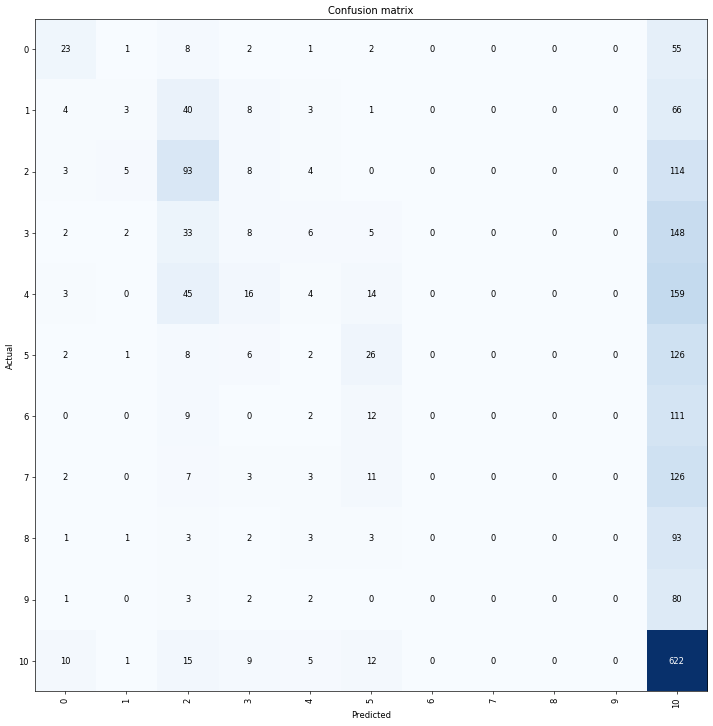

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.top_losses()
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)